# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = random_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 126, 0.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves', xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [14]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.3770 - acc: 0.7024 - val_loss: 0.6521 - val_acc: 0.6429
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3595 - acc: 0.7024 - val_loss: 0.6161 - val_acc: 0.6587
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.3458 - acc: 0.7103 - val_loss: 0.5811 - val_acc: 0.6508
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.3317 - acc: 0.7103 - val_loss: 0.5523 - val_acc: 0.6508
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3215 - acc: 0.7222 - val_loss: 0.5258 - val_acc: 0.6508
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3105 - acc: 0.7143 - val_loss: 0.5037 - val_acc: 0.6508
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3030 - acc: 0.7183 - val_loss: 0.4827 - val_acc: 0.6746
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.2948 - acc

252/252 [==============================] - 0s - loss: 0.1174 - acc: 0.8532 - val_loss: 0.1636 - val_acc: 0.8492
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1173 - acc: 0.8532 - val_loss: 0.1625 - val_acc: 0.8492
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1170 - acc: 0.8532 - val_loss: 0.1630 - val_acc: 0.8492
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1168 - acc: 0.8532 - val_loss: 0.1628 - val_acc: 0.8492
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1166 - acc: 0.8532 - val_loss: 0.1631 - val_acc: 0.8492
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1165 - acc: 0.8532 - val_loss: 0.1633 - val_acc: 0.8492
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1162 - acc: 0.8571 - val_loss: 0.1633 - val_acc: 0.8492
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1160 - acc: 0.8571 - val_loss: 0.1632 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.1053 - acc: 0.8889 - val_loss: 0.1600 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - ETA: 0s - loss: 0.0549 - acc: 0.968 - 0s - loss: 0.1052 - acc: 0.8849 - val_loss: 0.1599 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.1052 - acc: 0.8849 - val_loss: 0.1600 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.1052 - acc: 0.8929 - val_loss: 0.1601 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.1052 - acc: 0.8889 - val_loss: 0.1594 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.1050 - acc: 0.8849 - val_loss: 0.1596 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.1050 - acc: 0.8849 - val_loss: 0.1595 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.1050 - acc: 0.888

252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8968 - val_loss: 0.1438 - val_acc: 0.8571
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8968 - val_loss: 0.1432 - val_acc: 0.8571
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8968 - val_loss: 0.1431 - val_acc: 0.8571
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8968 - val_loss: 0.1429 - val_acc: 0.8571
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8968 - val_loss: 0.1429 - val_acc: 0.8571
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8968 - val_loss: 0.1423 - val_acc: 0.8571
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8968 - val_loss: 0.1426 - val_acc: 0.8571
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8968 - val_loss: 0.1419 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9087 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9087 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.9087 - val_loss: 0.1110 - val_acc: 0.8889
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9087 - val_loss: 0.1109 - val_acc: 0.8889
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.9087 - val_loss: 0.1106 - val_acc: 0.8889
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9087 - val_loss: 0.1106 - val_acc: 0.8889
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9087 - val_loss: 0.1102 - val_acc: 0.8968
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9087 - val_loss: 0.1101 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9087 - val_loss: 0.1032 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9087 - val_loss: 0.1031 - val_acc: 0.8889
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9087 - val_loss: 0.1030 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9087 - val_loss: 0.1031 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1030 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1030 - val_acc: 0.8889
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1029 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9087 - val_loss: 0.1030 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9127 - val_loss: 0.1021 - val_acc: 0.8889
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1020 - val_acc: 0.8889
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1021 - val_acc: 0.8889
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8889
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8889
Epoch 710/2000
252/252 [==============================] - ETA: 0s - loss: 0.0779 - acc: 0.906 - 0s - loss: 0.0811 - acc: 0.9127 - val_loss: 0.1019 - val_acc: 0.8889
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9127 - val_loss: 0.1021 - val_acc: 0.8889
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.912

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9167 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9167 - val_loss: 0.1016 - val_acc: 0.8968
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9167 - val_loss: 0.1014 - val_acc: 0.8968
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9167 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9167 - val_loss: 0.1014 - val_acc: 0.8968
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9167 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9167 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9167 - val_loss: 0.1013 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1012 - val_acc: 0.8968
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 963/2000
252/252 [==============================] - ETA: 0s - loss: 0.1227 - acc: 0.843 - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9087 - val_loss: 0.1012 - val_acc: 0.8968
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1010 - val_acc: 0.8968
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.912

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1010 - val_acc: 0.8968
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1014 - val_acc:

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1015 - val_acc: 0.8889
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1013 - val_acc: 0.8889
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1010 - val_acc: 0.8968
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1011 - val_acc: 0.8889
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1012 - val_acc: 0.8889
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1014 - val_acc: 0.8889
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1012 - val_acc: 0.8889
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1013 - val_acc:

252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1017 - val_acc: 0.8889
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1019 - val_acc: 0.8889
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1015 - val_acc: 0.8889
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1014 - val_acc: 0.8889
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1015 - val_acc: 0.8889
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8889
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1018 - val_acc: 0.8889
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1018 - val_acc:

252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1019 - val_acc: 0.8810
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1020 - val_acc: 0.8810
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1018 - val_acc: 0.8810
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8889
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8889
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1018 - val_acc:

252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1019 - val_acc: 0.8810
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1018 - val_acc: 0.8810
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1017 - val_acc:

252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8810
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1014 - val_acc: 0.8810
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1014 - val_acc: 0.8810
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1018 - val_acc: 0.8810
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8810
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1018 - val_acc: 0.8810
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1017 - val_acc:

252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1014 - val_acc: 0.8810
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1016 - val_acc: 0.8810
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1016 - val_acc: 0.8810
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8810
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1014 - val_acc: 0.8810
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1016 - val_acc: 0.8810
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1019 - val_acc: 0.8810
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1015 - val_acc:

252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8730
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8810
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8730
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1016 - val_acc: 0.8810
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8810
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8810
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1015 - val_acc:

In [15]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1024/1962 [==============>...............] - ETA: 0s[0.060016574013397231, 0.92354740061162077]


<IPython.core.display.Javascript object>


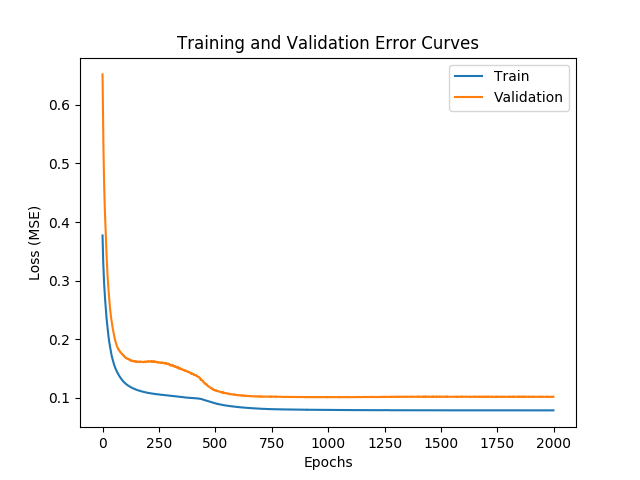

<IPython.core.display.Javascript object>


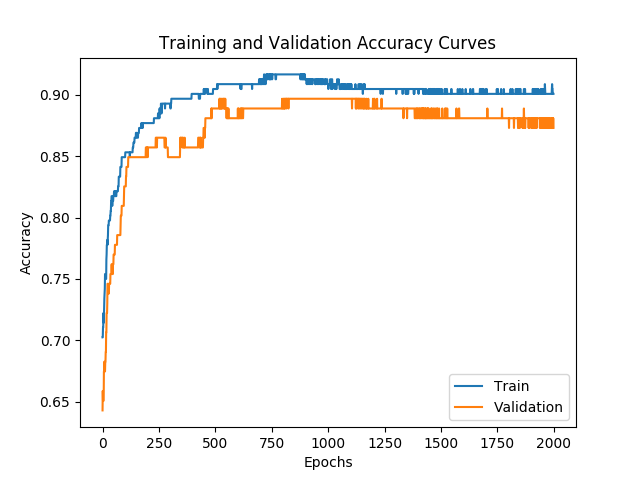

In [16]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 2 (5)

In [18]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4055 - acc: 0.5040 - val_loss: 0.4003 - val_acc: 0.5238
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3823 - acc: 0.5119 - val_loss: 0.3782 - val_acc: 0.5238
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.3588 - acc: 0.5198 - val_loss: 0.3553 - val_acc: 0.5317
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.3325 - acc: 0.5238 - val_loss: 0.3306 - val_acc: 0.5317
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3070 - acc: 0.5476 - val_loss: 0.3052 - val_acc: 0.5476
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.2816 - acc: 0.5635 - val_loss: 0.2836 - val_acc: 0.5635
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.2581 - acc: 0.5833 - val_loss: 0.2648 - val_acc: 0.5873
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.2362 - acc

252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1077 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9087 - val_loss: 0.1076 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9087 - val_loss: 0.1075 - val_acc: 0.8651
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9087 - val_loss: 0.1074 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9087 - val_loss: 0.1073 - val_acc: 0.8651
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.1073 - val_acc: 0.8571
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.1068 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1050 - val_acc: 0.8810
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1052 - val_acc: 0.8730
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1051 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1053 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1050 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9206 - val_loss: 0.1053 - val_acc: 0.8730
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1052 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9206 - val_loss: 0.1052 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1105 - val_acc: 0.8651
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1104 - val_acc: 0.8651
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1107 - val_acc: 0.8651
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9206 - val_loss: 0.1107 - val_acc: 0.8651
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9206 - val_loss: 0.1108 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9246 - val_loss: 0.1136 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1139 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9246 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1136 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9246 - val_loss: 0.1133 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1136 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9246 - val_loss: 0.1140 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1137 - val_acc: 0.8571
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1146 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1143 - val_acc: 0.8571
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1141 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9246 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9246 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9246 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9246 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9246 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1092 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9286 - val_loss: 0.1091 - val_acc: 0.8730
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9286 - val_loss: 0.1092 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1113 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1115 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1115 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1116 - val_acc: 0.8730
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9286 - val_loss: 0.1135 - val_acc: 0.8730
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1135 - val_acc: 0.8730
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1130 - val_acc: 0.8730
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8730
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8730
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1135 - val_acc: 0.8730
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1138 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9325 - val_loss: 0.1137 - val_acc: 0.8492
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9325 - val_loss: 0.1137 - val_acc: 0.8571
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1140 - val_acc: 0.8571
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1138 - val_acc: 0.8492
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1137 - val_acc: 0.8571
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1138 - val_acc: 0.8571
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9325 - val_loss: 0.1134 - val_acc:

252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1132 - val_acc: 0.8492
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1135 - val_acc: 0.8571
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8492
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8492
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1135 - val_acc: 0.8571
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1137 - val_acc:

252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1140 - val_acc: 0.8571
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.1142 - val_acc: 0.8571
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1141 - val_acc: 0.8492
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9286 - val_loss: 0.1138 - val_acc: 0.8492
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1139 - val_acc:

252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9325 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1129 - val_acc: 0.8492
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1129 - val_acc: 0.8492
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9325 - val_loss: 0.1130 - val_acc: 0.8571
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8492
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1128 - val_acc:

252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9365 - val_loss: 0.1067 - val_acc: 0.8730
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9365 - val_loss: 0.1066 - val_acc: 0.8730
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9365 - val_loss: 0.1069 - val_acc: 0.8730
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9365 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9325 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9325 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9365 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9365 - val_loss: 0.1071 - val_acc:

252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9365 - val_loss: 0.1075 - val_acc: 0.8651
Epoch 1725/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9365 - val_loss: 0.1070 - val_acc: 0.8651
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9365 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9405 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9405 - val_loss: 0.1068 - val_acc: 0.8651
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9405 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9405 - val_loss: 0.1069 - val_acc: 0.8651
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9405 - val_loss: 0.1071 - val_acc:

252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1070 - val_acc: 0.8651
Epoch 1852/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1070 - val_acc: 0.8651
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1075 - val_acc: 0.8571
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9405 - val_loss: 0.1078 - val_acc: 0.8571
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1068 - val_acc: 0.8651
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1070 - val_acc: 0.8651
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9405 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1076 - val_acc:

252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9405 - val_loss: 0.1071 - val_acc: 0.8571
Epoch 1979/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9444 - val_loss: 0.1069 - val_acc: 0.8651
Epoch 1980/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9405 - val_loss: 0.1078 - val_acc: 0.8571
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9405 - val_loss: 0.1074 - val_acc: 0.8571
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9405 - val_loss: 0.1074 - val_acc: 0.8571
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9444 - val_loss: 0.1072 - val_acc: 0.8571
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9405 - val_loss: 0.1077 - val_acc: 0.8571
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9405 - val_loss: 0.1075 - val_acc:

In [19]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1440/1962 [=====================>........] - ETA: 0s[0.062372322833197803, 0.90417940876656477]


<IPython.core.display.Javascript object>


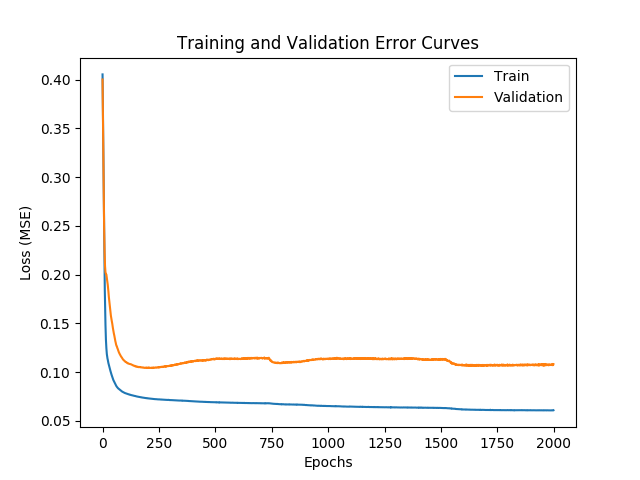

<IPython.core.display.Javascript object>


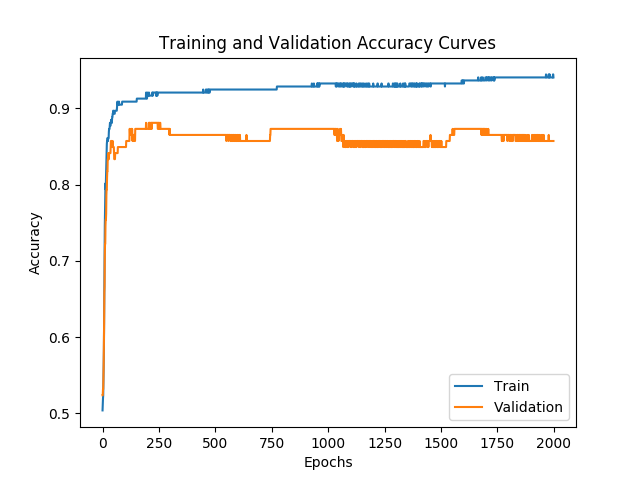

In [20]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 3 (3, 5)

In [22]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5611 - acc: 0.4048 - val_loss: 0.5253 - val_acc: 0.4762
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5479 - acc: 0.4206 - val_loss: 0.5156 - val_acc: 0.4683
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5366 - acc: 0.4206 - val_loss: 0.5067 - val_acc: 0.4683
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5258 - acc: 0.4325 - val_loss: 0.4982 - val_acc: 0.4683
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5163 - acc: 0.4524 - val_loss: 0.4900 - val_acc: 0.4603
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5064 - acc: 0.4563 - val_loss: 0.4800 - val_acc: 0.4762
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4909 - acc: 0.4603 - val_loss: 0.4643 - val_acc: 0.4921
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4690 - acc

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9048 - val_loss: 0.0995 - val_acc: 0.8810
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9048 - val_loss: 0.0994 - val_acc: 0.8810
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9048 - val_loss: 0.0995 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9087 - val_loss: 0.0992 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9087 - val_loss: 0.0990 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9087 - val_loss: 0.0989 - val_acc: 0.8810
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.0989 - val_acc: 0.8810
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9087 - val_loss: 0.0987 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9087 - val_loss: 0.0932 - val_acc: 0.9048
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9127 - val_loss: 0.0936 - val_acc: 0.9048
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9127 - val_loss: 0.0933 - val_acc: 0.9048
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9087 - val_loss: 0.0934 - val_acc: 0.9048
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9167 - val_loss: 0.0941 - val_acc: 0.8889
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9167 - val_loss: 0.0939 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9127 - val_loss: 0.0936 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9127 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9206 - val_loss: 0.0937 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 513/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0952 - val_acc: 0.8730
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9206 - val_loss: 0.0955 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0953 - val_acc: 0.8730
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0949 - val_acc: 0.8730
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9127 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0963 - val_acc: 0.8730
Epoch 641/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9206 - val_loss: 0.0966 - val_acc: 0.8810
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9206 - val_loss: 0.0964 - val_acc: 0.8730
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0960 - val_acc: 0.8730
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9206 - val_loss: 0.0964 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 769/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0977 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0973 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0980 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0978 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730
Epoch 897/2000
252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9206 - val_loss: 0.0994 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0998 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9206 - val_loss: 0.0995 - val_acc: 0.8730
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.8730
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1025/2000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9206 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9206 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1006 - val_acc:

252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9246 - val_loss: 0.1044 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9246 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1036 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9246 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1043 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9246 - val_loss: 0.1044 - val_acc:

252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1056 - val_acc: 0.8810
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1063 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1060 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9206 - val_loss: 0.1060 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9206 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9246 - val_loss: 0.1069 - val_acc: 0.8730
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9206 - val_loss: 0.1068 - val_acc:

252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9246 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9206 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9206 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9206 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9206 - val_loss: 0.1078 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9206 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9246 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9246 - val_loss: 0.1075 - val_acc:

252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9206 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9246 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9206 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9167 - val_loss: 0.1091 - val_acc: 0.8810
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9167 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1090 - val_acc:

252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8810
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1111 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9206 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0539 - acc: 0.9167 - val_loss: 0.1113 - val_acc: 0.8810
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1111 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9167 - val_loss: 0.1110 - val_acc:

252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9246 - val_loss: 0.1119 - val_acc: 0.8810
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9246 - val_loss: 0.1117 - val_acc: 0.8810
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9206 - val_loss: 0.1120 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1121 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1122 - val_acc: 0.8810
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.1124 - val_acc:

252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9286 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9246 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9286 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9286 - val_loss: 0.1143 - val_acc:

In [23]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1856/1962 [===========================>..] - ETA: 0s[0.095942563334599551, 0.87359836901121302]


<IPython.core.display.Javascript object>


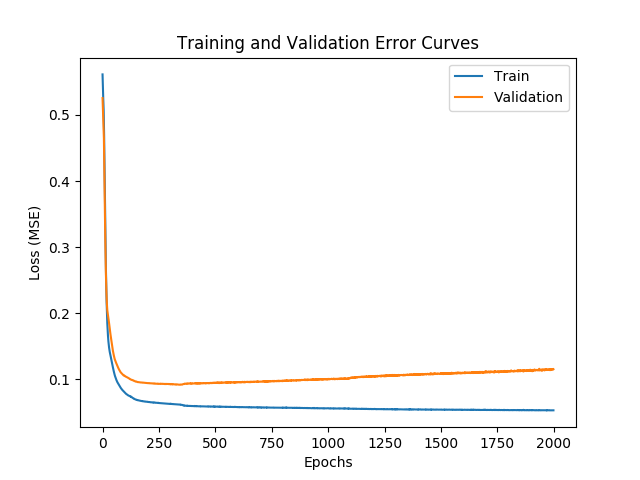

<IPython.core.display.Javascript object>


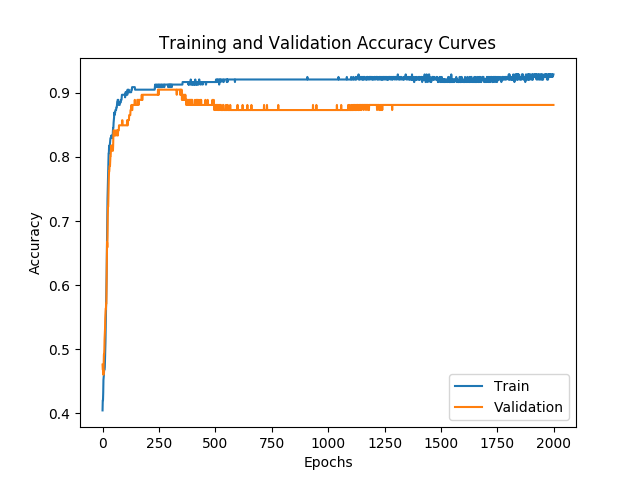

In [24]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 4 (5,3)

In [25]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5604 - acc: 0.4127 - val_loss: 0.5098 - val_acc: 0.4206
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5499 - acc: 0.4246 - val_loss: 0.5002 - val_acc: 0.4444
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5403 - acc: 0.4286 - val_loss: 0.4924 - val_acc: 0.4444
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5318 - acc: 0.4405 - val_loss: 0.4857 - val_acc: 0.4444
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5247 - acc: 0.4444 - val_loss: 0.4795 - val_acc: 0.4524
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5170 - acc: 0.4563 - val_loss: 0.4741 - val_acc: 0.4762
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.5104 - acc: 0.4563 - val_loss: 0.4684 - val_acc: 0.4762
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.5031 - acc

252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.8929 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.8929 - val_loss: 0.1135 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.8929 - val_loss: 0.1134 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.8929 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.8929 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.8929 - val_loss: 0.1134 - val_acc: 0.8810
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.8929 - val_loss: 0.1133 - val_acc: 0.8810
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.8929 - val_loss: 0.1129 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1081 - val_acc: 0.8968
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9048 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8968
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8968
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9048 - val_loss: 0.1075 - val_acc: 0.8968
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8968
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9048 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1064 - val_acc: 0.8968
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1065 - val_acc: 0.8968
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1073 - val_acc: 0.8968
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1064 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8968
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1057 - val_acc: 0.8889
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.1062 - val_acc: 0.8968
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1052 - val_acc: 0.8889
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1061 - val_acc: 0.8889
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1064 - val_acc: 0.8968
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.1059 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1065 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1064 - val_acc: 0.8810
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1069 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1062 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9167 - val_loss: 0.1061 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9167 - val_loss: 0.1056 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1066 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1065 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9206 - val_loss: 0.1083 - val_acc: 0.8810
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9206 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9167 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9206 - val_loss: 0.1083 - val_acc: 0.8810
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9206 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9206 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9246 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9246 - val_loss: 0.1087 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9286 - val_loss: 0.1122 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1120 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9286 - val_loss: 0.1113 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1117 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.1132 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.1128 - val_acc: 0.8651
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9286 - val_loss: 0.1134 - val_acc: 0.8730
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9325 - val_loss: 0.1122 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9325 - val_loss: 0.1167 - val_acc: 0.8651
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9325 - val_loss: 0.1166 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9325 - val_loss: 0.1170 - val_acc: 0.8730
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9325 - val_loss: 0.1180 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9325 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9325 - val_loss: 0.1177 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9325 - val_loss: 0.1184 - val_acc: 0.8730
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9325 - val_loss: 0.1168 - val_acc:

252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1209 - val_acc: 0.8730
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1206 - val_acc: 0.8730
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.1203 - val_acc: 0.8730
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1201 - val_acc: 0.8730
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.1207 - val_acc: 0.8730
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1207 - val_acc: 0.8651
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1200 - val_acc: 0.8730
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.1205 - val_acc:

252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.1212 - val_acc: 0.8730
Epoch 1279/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1209 - val_acc: 0.8730
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.1212 - val_acc: 0.8730
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9325 - val_loss: 0.1223 - val_acc: 0.8730
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1201 - val_acc: 0.8730
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1208 - val_acc: 0.8730
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1216 - val_acc: 0.8730
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.1202 - val_acc:

252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.1188 - val_acc: 0.8730
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9325 - val_loss: 0.1198 - val_acc: 0.8730
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9325 - val_loss: 0.1191 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.1195 - val_acc: 0.8730
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.1188 - val_acc: 0.8730
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.1191 - val_acc: 0.8730
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9365 - val_loss: 0.1187 - val_acc: 0.8651
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9365 - val_loss: 0.1193 - val_acc:

252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.0595 - acc: 0.9325 - val_loss: 0.1178 - val_acc: 0.8730
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9325 - val_loss: 0.1176 - val_acc: 0.8651
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.1183 - val_acc: 0.8651
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.1188 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.1168 - val_acc:

252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1661/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1177 - val_acc: 0.8651
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1183 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1177 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.1177 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.1163 - val_acc:

252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9365 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1166 - val_acc: 0.8651
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1180 - val_acc: 0.8651
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9365 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1176 - val_acc:

252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1915/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 1916/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1167 - val_acc: 0.8651
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9365 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9365 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1173 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9365 - val_loss: 0.1177 - val_acc:

In [26]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1888/1962 [===========================>..] - ETA: 0s[0.057958604170889549, 0.92711518858307851]


<IPython.core.display.Javascript object>


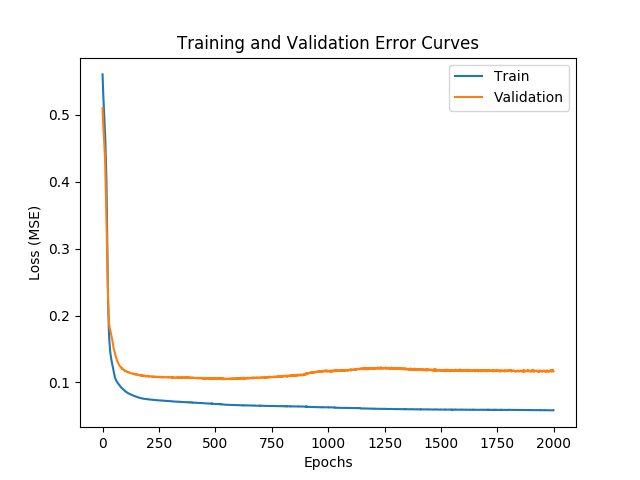

<IPython.core.display.Javascript object>


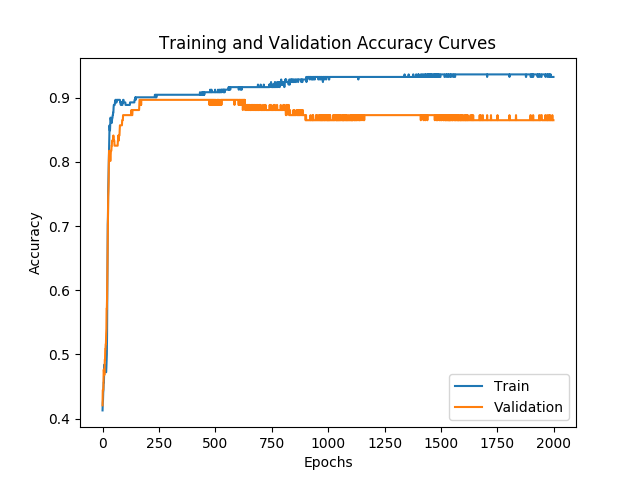

In [27]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 5 (2)

In [28]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 1.1074 - acc: 0.4246 - val_loss: 1.1262 - val_acc: 0.4206
Epoch 2/2000
252/252 [==============================] - 0s - loss: 1.0543 - acc: 0.4246 - val_loss: 1.0780 - val_acc: 0.4286
Epoch 3/2000
252/252 [==============================] - 0s - loss: 1.0118 - acc: 0.4206 - val_loss: 1.0285 - val_acc: 0.4365
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.9623 - acc: 0.4246 - val_loss: 0.9861 - val_acc: 0.4444
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.9267 - acc: 0.4325 - val_loss: 0.9435 - val_acc: 0.4444
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.8843 - acc: 0.4444 - val_loss: 0.9073 - val_acc: 0.4524
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.8517 - acc: 0.4365 - val_loss: 0.8719 - val_acc: 0.4603
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.8181 - acc

252/252 [==============================] - 0s - loss: 0.2049 - acc: 0.7262 - val_loss: 0.2107 - val_acc: 0.7222
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.2031 - acc: 0.7302 - val_loss: 0.2094 - val_acc: 0.7222
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.2016 - acc: 0.7381 - val_loss: 0.2081 - val_acc: 0.7302
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.2002 - acc: 0.7381 - val_loss: 0.2066 - val_acc: 0.7302
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1988 - acc: 0.7381 - val_loss: 0.2053 - val_acc: 0.7302
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1974 - acc: 0.7381 - val_loss: 0.2040 - val_acc: 0.7302
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1961 - acc: 0.7381 - val_loss: 0.2028 - val_acc: 0.7302
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1947 - acc: 0.7381 - val_loss: 0.2015 - val_acc: 0.7381

252/252 [==============================] - 0s - loss: 0.1332 - acc: 0.8175 - val_loss: 0.1445 - val_acc: 0.7937
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.1329 - acc: 0.8175 - val_loss: 0.1442 - val_acc: 0.7857
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.1326 - acc: 0.8175 - val_loss: 0.1440 - val_acc: 0.7857
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.1322 - acc: 0.8175 - val_loss: 0.1437 - val_acc: 0.7857
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.1320 - acc: 0.8175 - val_loss: 0.1435 - val_acc: 0.7857
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.1317 - acc: 0.8175 - val_loss: 0.1432 - val_acc: 0.7937
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.1313 - acc: 0.8175 - val_loss: 0.1429 - val_acc: 0.7937
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.1310 - acc: 0.8175 - val_loss: 0.1428 - val_acc: 0.7937

252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8849 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8849 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0936 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1135 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8810
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1127 - val_acc: 0.8810
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8810
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8810
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8810
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc:

252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1099 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8730
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc:

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8730
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8730
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc:

252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc:

In [29]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1440/1962 [=====================>........] - ETA: 0s[0.060406785994714982, 0.92354740061162077]


<IPython.core.display.Javascript object>


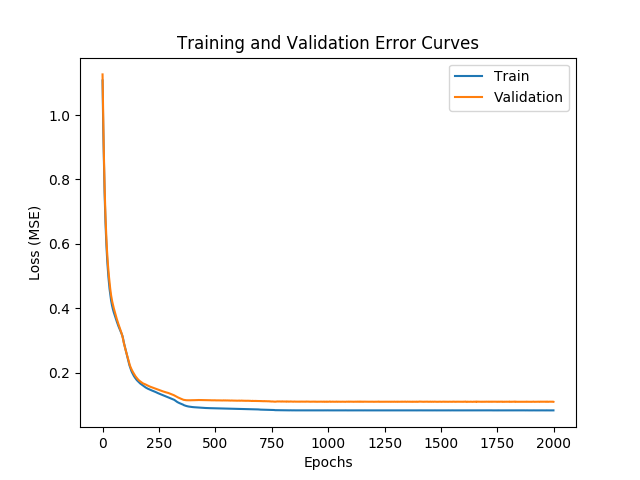

<IPython.core.display.Javascript object>


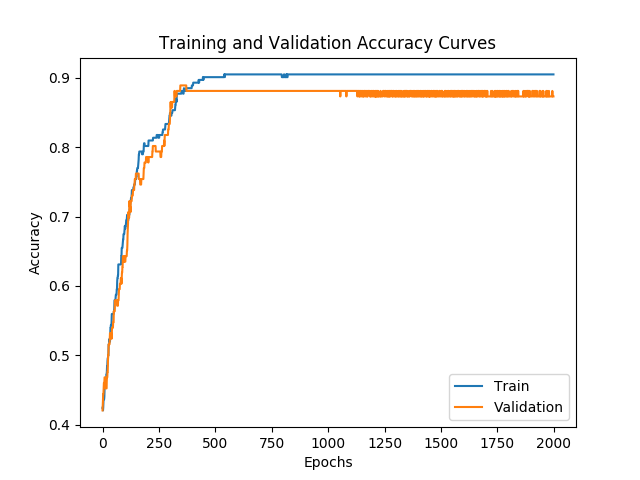

In [30]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 6 (4)

In [31]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4173 - acc: 0.5159 - val_loss: 0.4161 - val_acc: 0.4921
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3903 - acc: 0.5278 - val_loss: 0.3954 - val_acc: 0.5079
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.3678 - acc: 0.5476 - val_loss: 0.3775 - val_acc: 0.5397
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.3480 - acc: 0.5833 - val_loss: 0.3621 - val_acc: 0.5556
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3305 - acc: 0.6151 - val_loss: 0.3491 - val_acc: 0.5873
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3132 - acc: 0.6310 - val_loss: 0.3382 - val_acc: 0.6032
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.2987 - acc: 0.6468 - val_loss: 0.3287 - val_acc: 0.6349
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.2847 - acc

252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8849 - val_loss: 0.1280 - val_acc: 0.8492
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8889 - val_loss: 0.1274 - val_acc: 0.8492
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8889 - val_loss: 0.1272 - val_acc: 0.8492
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1273 - val_acc: 0.8492
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.8849 - val_loss: 0.1267 - val_acc: 0.8571
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8849 - val_loss: 0.1266 - val_acc: 0.8571
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8849 - val_loss: 0.1262 - val_acc: 0.8571
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.8849 - val_loss: 0.1257 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1121 - val_acc: 0.8571
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1119 - val_acc: 0.8492
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1121 - val_acc: 0.8492
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8492
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1122 - val_acc: 0.8571
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1118 - val_acc: 0.8492
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1115 - val_acc: 0.8492
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1110 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9127 - val_loss: 0.1040 - val_acc: 0.8571
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9127 - val_loss: 0.1038 - val_acc: 0.8571
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9127 - val_loss: 0.1035 - val_acc: 0.8571
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9127 - val_loss: 0.1034 - val_acc: 0.8571
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9127 - val_loss: 0.1027 - val_acc: 0.8571
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9127 - val_loss: 0.1030 - val_acc: 0.8571
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9127 - val_loss: 0.1032 - val_acc: 0.8571
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9127 - val_loss: 0.1035 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9167 - val_loss: 0.0982 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.8730
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9167 - val_loss: 0.0984 - val_acc: 0.8730
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8730
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8730
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8730
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8730
Epoch 647/2000
252/252 [==============================] - ETA: 0s - loss: 0.0512 - acc: 0.906 - 0s - loss: 0.0711 - acc: 0.9127 - val_loss: 0.0959 - val_acc: 0.8730
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.912

252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9087 - val_loss: 0.0938 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9127 - val_loss: 0.0937 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9127 - val_loss: 0.0935 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0932 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9087 - val_loss: 0.0933 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9127 - val_loss: 0.0933 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0934 - val_acc: 0.8730
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0933 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0926 - val_acc: 0.8810
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0929 - val_acc: 0.8810
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9127 - val_loss: 0.0925 - val_acc: 0.8810
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0921 - val_acc: 0.8810
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0921 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0927 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0924 - val_acc: 0.8810
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0927 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9087 - val_loss: 0.0920 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9127 - val_loss: 0.0922 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9127 - val_loss: 0.0918 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9087 - val_loss: 0.0914 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9087 - val_loss: 0.0915 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9127 - val_loss: 0.0918 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9127 - val_loss: 0.0920 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9127 - val_loss: 0.0918 - val_acc:

252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9087 - val_loss: 0.0911 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9087 - val_loss: 0.0914 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9087 - val_loss: 0.0910 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9087 - val_loss: 0.0910 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9127 - val_loss: 0.0916 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9127 - val_loss: 0.0915 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9087 - val_loss: 0.0912 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9087 - val_loss: 0.0915 - val_acc:

252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9087 - val_loss: 0.0911 - val_acc: 0.8810
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9087 - val_loss: 0.0909 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9087 - val_loss: 0.0912 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9087 - val_loss: 0.0908 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9087 - val_loss: 0.0910 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9087 - val_loss: 0.0911 - val_acc: 0.8810
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9087 - val_loss: 0.0910 - val_acc: 0.8810
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9087 - val_loss: 0.0911 - val_acc:

252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0903 - val_acc: 0.8889
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0904 - val_acc: 0.8889
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0908 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.0907 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.0904 - val_acc: 0.8889
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0905 - val_acc: 0.8889
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.0908 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.0912 - val_acc:

252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9127 - val_loss: 0.0906 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.0903 - val_acc: 0.8889
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9127 - val_loss: 0.0901 - val_acc: 0.8889
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9127 - val_loss: 0.0907 - val_acc: 0.8810
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.0906 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.0907 - val_acc: 0.8810
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9087 - val_loss: 0.0907 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9127 - val_loss: 0.0900 - val_acc:

252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9206 - val_loss: 0.0890 - val_acc: 0.8810
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9167 - val_loss: 0.0887 - val_acc: 0.8810
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9206 - val_loss: 0.0888 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9206 - val_loss: 0.0885 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9206 - val_loss: 0.0889 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9206 - val_loss: 0.0887 - val_acc: 0.8810
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9206 - val_loss: 0.0881 - val_acc: 0.8889
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9206 - val_loss: 0.0887 - val_acc:

252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9206 - val_loss: 0.0881 - val_acc: 0.8889
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9206 - val_loss: 0.0875 - val_acc: 0.8889
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9206 - val_loss: 0.0878 - val_acc: 0.8889
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9206 - val_loss: 0.0881 - val_acc: 0.8889
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9206 - val_loss: 0.0881 - val_acc: 0.8889
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9206 - val_loss: 0.0875 - val_acc: 0.8889
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9206 - val_loss: 0.0876 - val_acc: 0.8889
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9206 - val_loss: 0.0879 - val_acc:

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9206 - val_loss: 0.0881 - val_acc: 0.8810
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9206 - val_loss: 0.0878 - val_acc: 0.8889
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9206 - val_loss: 0.0874 - val_acc: 0.8889
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9206 - val_loss: 0.0875 - val_acc: 0.8889
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9206 - val_loss: 0.0877 - val_acc: 0.8889
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9206 - val_loss: 0.0873 - val_acc: 0.8889
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9206 - val_loss: 0.0875 - val_acc: 0.8889
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9206 - val_loss: 0.0878 - val_acc:

In [32]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1536/1962 [======================>.......] - ETA: 0s[0.081182577819103013, 0.89500509683995921]


<IPython.core.display.Javascript object>


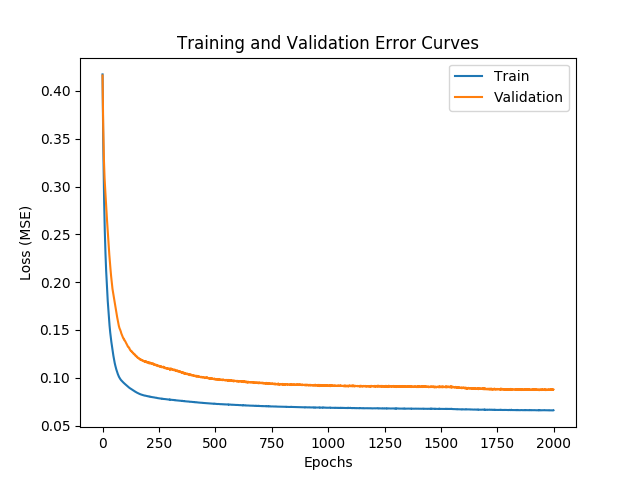

<IPython.core.display.Javascript object>


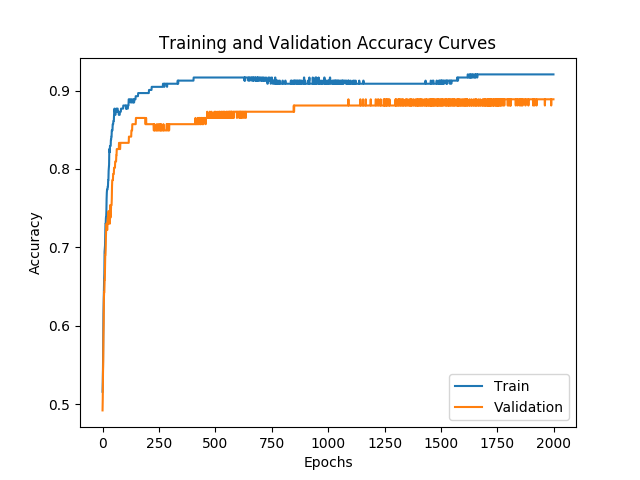

In [33]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [121]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1774  124]
 [   9   55]]

Train Loss:       0.0725
Validation Loss:  0.0816
Accuracy:         0.9322
Recall:           0.8594
Precision:        0.3073
F1:               0.4527
AUROC:            0.9239
